# Load libraries and packages

In [9]:
## general
import numpy as np
import pandas as pd
import xarray as xr
import copy
import numpy.ma as ma
# from itertools import compress
# from sklearn.externals import joblib
import os
import regionmask
import time 
import geopandas
import cftime
from tqdm import tqdm

## plotting
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import from_levels_and_colors
from matplotlib.lines import Line2D 
import cartopy.crs as ccrs
from matplotlib.colors import LogNorm
import mplotutils as mpu

## statistics
#from statsmodels.nonparametric.smoothers_lowess import lowess # lowess filter
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr

# extra stuff for Lea's loading codes
import glob
from datetime import datetime

# Define functions

In [10]:
def norm_cos_wgt(lats):
    
    from numpy import cos, deg2rad
    
    return np.cos(np.deg2rad(lats))

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [11]:
def load_data_single_mod_mon(gen,model, mon, GMST=False, Tref_all=True,Tref_start='1870-01-01',Tref_end='1900-01-01',usr_time_res="ann"):

    """ Load the all initial-condition members of a single model in cmip5 or cmip6 for given scenario plus associated historical period.

    Keyword argument:
    gen: generation (cmip5 = 5 and cmip6 = 6 are implemented)
    model: model str
    mon: month integer, where 1 is Jan, 12 is Dec
    scenario: scenario str
    GMST: decides if wgt Tanglob is computed (and returned) or not, default is not returned
    Tref_all: decides if the Tref at each grid point is dervied based on all available runs or not, default is yes       
    Tref_start: starting point for the reference period with default 1870
    Tref_end: first year to no longer be included in reference period with default 1900

    Output:
    y: the land grid points of the anomalies of the variable on grid centered over 0 longitude (like the srexgrid) 
    time: the time slots
    srex: the gridded srex regions
    df_srex: data frame containing the shape files of the srex regions
    lon_pc: longitudes for pcolormesh (needs 1 more than on grid)
    lat_pc: latitudes for pcolormesh (needs 1 more than on grid)
    idx_l: array with 0 where sea, 1 where land (assumption: land if frac land > 0)
    wgt_l: land grid point weights to derive area weighted mean vars
    Tan_wgt_globmean = area weighted global mean temperature

    """
    print("start with model", model, "for month: ", mon)
    
    month_sel = mon
    var='tas'
    temp_res=usr_time_res
    spatial_res='g025'
        
    ##load in constant files
    dir_data = "/home/tristan/mesmer/data/"
    file_ls = "interim_invariant_lsmask_regrid.nc"
    file_srex = "srex-region-masks_20120709.srex_mask_SREX_masks_all.25deg.time-invariant.nc"
    file_srex_shape = "referenceRegions.shp"
        
    # SREX names ordered according to SREX mask
    srex_names = ['ALA','CGI','WNA','CNA','ENA','CAM','AMZ','NEB','WSA','SSA','NEU','CEU','MED','SAH','WAF','EAF','SAF',
             'NAS','WAS','CAS','TIB','EAS','SAS','SEA','NAU','SAU'] 
        
    # srex_raw nrs from 1-26
    srex_raw = xr.open_mfdataset(dir_data+file_srex, combine='by_coords',decode_times=False) 
    lons, lats = np.meshgrid(srex_raw.lon.values,srex_raw.lat.values) #derive the lat, lon grid
    
    #apply land mask
    frac_l = xr.open_mfdataset(dir_data+file_ls, combine='by_coords',decode_times=False) #land-sea mask
    frac_l_raw = np.squeeze(copy.deepcopy(frac_l.lsm.values))
    frac_l = frac_l.where(frac_l.lat>-60,0)
    idx_l=np.squeeze(frac_l.lsm.values)>0.0 
    
    wgt = np.cos(np.deg2rad(lats)) # area weights of each grid point
    wgt_l = (wgt*frac_l_raw)[idx_l] # area weights for land grid points (including taking fraction land into consideration)
    lon_pc, lat_pc = mpu.infer_interval_breaks(frac_l.lon, frac_l.lat) # the lon / lat for the plotting with pcolormesh
    srex = (np.squeeze(srex_raw.srex_mask.values)-1)[idx_l] # srex indices on land
    
    y={}
    T_ref = np.zeros(idx_l.shape)
    run_nrs={}
    
    if GMST == True:
        Tan_wgt_globmean = {}
        Tan_wgt_globmean_hist = {}
    if gen == 6:
        dir_var= '/home/tristan/mesmer_data/CMIP6/tas/%s/g025/'%usr_time_res  #select the correct directory
        
        run_names_list = sorted(glob.glob(dir_var+var+'_'+temp_res+'_'+model+'_ssp*_'+'r*i1p1f*'+'_'+spatial_res+'.nc'))
        run_names_list_historical=sorted(glob.glob(dir_var+var+'_'+temp_res+'_'+model+'_historical_'+'r*i1p1f*'+'_'+spatial_res+'.nc'))
        
        for run_name in run_names_list:
            run_name_ssp = run_name
            
            data = xr.open_mfdataset(run_name_ssp, concat_dim='time', combine="nested").sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
            #data = data.sel(time=data.time.dt.month.isin([month_sel])) ## select specific month(s) from the data
            data = data.assign_coords(lon= (((data.lon + 180) % 360) - 180)) #assign coords so same labels as others
            scen = run_name.split('/')[-1].split('_')[-3]
            run = int(run_name.split('/')[-1].split('_')[-2].split('r')[1].split('i')[0])
            
            if scen not in list(y.keys()):
                y[scen]={}
                run_nrs[scen]=[]
                y[scen][run] = data.tas.values  #still absolute values (contains also sea pixels)
                y[scen][run] = y[scen][run][mon::12]  # select the chosen month only 
                run_nrs[scen].append(run)
                
            else:
                y[scen][run] = data.tas.values
                y[scen][run] = y[scen][run][mon::12]  # select the chosen month only 
                run_nrs[scen].append(run)
        
            if GMST == True:
                Tan_wgt_globmean[run] = np.asarray([np.average(y[scen][run][t],weights=wgt) for t in np.arange(y[scen][run].shape[0])])
        
        y['historical']={}
        run_nrs['historical']=[]
        for run_name in run_names_list_historical:
            run_name_hist = run_name
            data_hist = xr.open_mfdataset(run_name_hist,concat_dim='time',  combine="nested").sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
            #data_hist = data_hist.sel(time=data_hist.time.dt.month.isin([month_sel])) ## select specific month(s) from the data
            run = int(run_name.split('/')[-1].split('_')[-2].split('r')[1].split('i')[0]) 
            y['historical'][run] = data_hist.tas.values
            y['historical'][run] = y['historical'][run][mon::12]  # select the chosen month only 
            run_nrs['historical'].append(run)
            
        #sum up all ref climates
            T_ref += data_hist.tas.sel(time=slice(Tref_start, Tref_end)).mean(dim='time').values*1.0/len(run_names_list_historical)
            y['historical'][run]=y['historical'][run][:,idx_l]
            
    for scen in [i for i in y.keys()]:
        print(scen, run_nrs[scen])
        for run in run_nrs[scen]:
            if Tref_all == True:
                try:
                    y[scen][run]=(y[scen][run]-T_ref)[:,idx_l]
                except:
                    y[scen][run]=(y[scen][run]-T_ref[idx_l])
                     #print('Exception dealth with, ', scen,y[scen][run].shape)
            else:
                try:
                    y[scen][run]=y[scen][run][:,idx_l]
                except:
                    y[scen][run]=y[scen][run]
                    print('No T ref, ', scen,y[scen][run].shape)
                    
    #if (data.lon!=srex_raw.lon).any() and (srex_raw.lon!=frac_l.lon).any():
        #print("There is an error. The grids do not agree.")
    
        
    time = data.sel(time=data.time.dt.month.isin([month_sel]))
    time= time["time"]
    
    time_hist = data_hist.sel(time=data_hist.time.dt.month.isin([month_sel]))
    time_hist= time_hist["time"]
    
    if GMST == False:
        if Tref_all == False:
            return y,time,time_hist,run_nrs, srex,srex_names,lon_pc,lat_pc,idx_l,wgt_l, T_ref
        else:
            return y,time,time_hist,run_nrs,srex,srex_names,lon_pc,lat_pc,idx_l,wgt_l
    else:
        return y,time,time_hist,run_nrs,srex,srex_names,lon_pc,lat_pc,idx_l,wgt_l,Tan_wgt_globmean

In [12]:
def load_data_obs_mon(obs, mon, Tref_start='1951-01-01', Tref_end='1981-01-01'):
    """ Load the observations.

    Keyword argument:
    - obs: currently implemented for "best" and "cowtan"
    - mon: int, specific month, where 1 is Jan and 12 is Dec
    - Tref_start: starting point for the reference period with default 1951 (ie BEST Tref)
    - Tref_end: last year still INCLUDED for the reference period with default 1980 (ie BEST Tref) (ATTENTION: different from load_data_single_mod where is the first NOT included)
    - Tblend_idx: whether to compute the blended Tanglob anomaly or not (default = False)

    Output:
    - y: the land grid points of the anomalies of the variable on grid centered over 0 longitude (like the srexgrid) 
    - time: the time slots
    - Tblendglob = area weighted global mean temperature (blend from SST over ocean and tas over land + sea ice)
        
            
    """
    print("start with ", obs, "for month: ", mon)
    
    dir_data = '/home/tristan/mesmer/data/'
    
    month_sel = mon
    nr_years = 112
    tot_months = 12*nr_years
    
    
    # read in the land-sea mask
    file_ls = 'interim_invariant_lsmask_regrid.nc' # ERA-interim mask regridded by Richard from 73x144 to 72x144
    frac_l = xr.open_mfdataset(dir_data+file_ls) #land-sea mask of ERA-interim bilinearily interpolated 
    frac_l = frac_l.where(frac_l.lat>-60,0) # remove Antarctica from frac_l field (ie set frac l to 0)
    idx_l=np.squeeze(frac_l.lsm.values)>0.0 # idex land #-> everything >0 I consider land

    lons, lats = np.meshgrid(frac_l.lon.values,frac_l.lat.values) # the lon, lat grid (just to derive weights)   
    wgt = norm_cos_wgt(lats) # area weights of each grid point
    
    if obs == 'best':
        obs_file='obs_data_25.nc'
        ds_obs=xr.open_mfdataset(dir_data+obs_file)
        ds_fix = ds_obs.rename({'temperature':'tas'}).sel(time=slice('1910-01-01', '2022-01-01'))
        ds_fix['time'] = np.arange(np.datetime64('1910-01-01'), np.datetime64('2022-01-01'), dtype='datetime64[M]')
        data_test = np.array([ds_fix.tas.values[:,idx_l]])
        data_test = data_test.squeeze()
        y_obs = data_test[month_sel::12]
    
    if obs == 'giss':
        file='GISS_tas_g25.nc' 
        ds_obs=xr.open_mfdataset(dir_data+file)
        ds_fix = ds_obs.rename({'tempanomaly':'tas'}).sel(time=slice('1910-01-01', '2022-01-01')).drop(['time_bnds'])
        ds_fix['time'] = np.arange(np.datetime64('1910-01-01'), np.datetime64('2022-01-01'), dtype='datetime64[M]')
        data_test = np.array([ds_fix.tas.values[:,idx_l]])
        data_test = data_test.squeeze()
        y_obs = data_test[month_sel::12]

    T_ref = np.array([ds_fix.tas.sel(time=slice(Tref_start, Tref_end)).mean(dim='time').values[idx_l]])
    T_ref = T_ref.squeeze()
    
    y=(y_obs-T_ref) #[:,idx_l]
    time = ds_fix.sel(time=ds_fix.time.dt.month.isin([month_sel]))
    time = time['time']
    
    return y,time

In [100]:
Tref_start='1951-01-01' 
Tref_end='1981-01-01'

datasets = ['best', 'giss']

y_obs = {}
ds_obs = {}
ds_fix = {}
data_test = {}
data_clim = {}
y_ma = {}
y_all_mon = {}
y_all = {}

for dataset in datasets:
    if dataset == 'best':
        obs_file='obs_data_25.nc'
        ds_obs[dataset]=xr.open_mfdataset(dir_data+obs_file)
        ds_fix[dataset] = ds_obs[dataset].rename({'temperature':'tas'}).sel(time=slice('1910-01-01', '2022-01-01'))
        
    if dataset == 'giss':
        file='GISS_tas_g25.nc' 
        ds_obs[dataset]=xr.open_mfdataset(dir_data+file)
        ds_fix[dataset] = ds_obs[dataset].rename({'tempanomaly':'tas'}).sel(time=slice('1910-01-01', '2022-01-01')).drop(['time_bnds'])
    
    ds_fix[dataset]['time'] = np.arange(np.datetime64('1910-01-01'), np.datetime64('2022-01-01'), dtype='datetime64[M]')
    data_test[dataset] = np.array([ds_fix[dataset].tas.values[:,idx_l]]).squeeze()
    data_clim[dataset] = np.array([ds_obs['best'].climatology.values[:,idx_l]]).squeeze()
    
    y_ma[dataset] = np.repeat(data_clim[dataset], 112, axis=0)
    
    y_all_mon[dataset] = np.add(y_ma[dataset], data_test[dataset])
    y_all_mon[dataset] = np.subtract(y_all_mon[dataset], np.reshape(np.tile(np.mean(ds_obs['best'].climatology.values[:,idx_l],axis=0), tot_months), (tot_months, idx_l.sum())))
    
y_all_mon['giss'].shape

(1344, 3043)

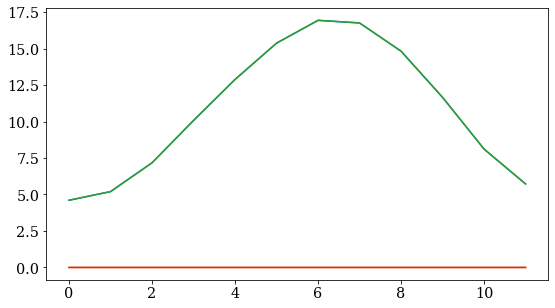

In [94]:
time_x = np.arange(12)

for dataset in datasets:
    plt.plot(time_x, np.mean(data_clim['best'], axis=1))
    plt.plot(time_x, np.mean(data_clim['giss'], axis=1))

In [13]:
def compute_Tan_wgt_reg(gen,reg,obs_idx=False):
    print(gen,reg)
    
    if reg == 'Global_land':
        idx_reg_l=np.ones(3043,dtype=bool)
        idx_reg_l_grid = copy.deepcopy(idx_l)
    
    else:   
        idx_reg = srex_names.index(reg) # index region
        idx_reg_l = (srex==idx_reg) #index land (l) gp inside specific srex region (reg)
        srex_grid=np.zeros(idx_l.shape)
        srex_grid[idx_l]=srex # ATTENTION: not 100% convinced yet if this is correct (I get some missing values that
        idx_reg_l_grid = (srex_grid==idx_reg)#& idx_l 
    
    Tan_wgt_reg_y={}
    Tan_wgt_reg_y_hist={}
    Tan_wgt_reg_y_mean={}
    Tan_wgt_reg_y_mean_hist={}
    Tan_wgt_reg_y_mean_all={}
    x = {}
    
    if gen == 6:
        models_sel = models
    
    for model in models_sel:
        Tan_wgt_reg_y[model]={}
        Tan_wgt_reg_y_hist[model]={}
        
        #### calculate the historical land surface temperature
        for run_nr in np.arange(len(y[model]['historical'])):   
            Tan_wgt_reg_y_hist[model][run_nr] = np.zeros(len(time_hist[model]))
            try:
                for i in np.arange(len(time_hist[model])):
                    Tan_wgt_reg_y_hist[model][run_nr][i] = np.average(y[model]['historical'][run_nr][i][idx_reg_l],weights=wgt_l[idx_reg_l])
        
            except:
                for i in np.arange(len(time_hist[model])):
                    Tan_wgt_reg_y_hist[model][run_nr][i] = np.average(y[model]['historical'][run_nr+1][i][idx_reg_l],weights=wgt_l[idx_reg_l])
        
        
        #### calculate the projected land surface temperature
        for run_nr in np.arange(len(y[model]['ssp585'])):
            Tan_wgt_reg_y[model][run_nr] = np.zeros(len(time[model]))
            try:
                for i in np.arange(len(time[model])):
                    Tan_wgt_reg_y[model][run_nr][i] = np.average(y[model]['ssp585'][run_nr][i][idx_reg_l],weights=wgt_l[idx_reg_l])
            except:
                for i in np.arange(len(time[model])):
                    Tan_wgt_reg_y[model][run_nr][i] = np.average(y[model]['ssp585'][run_nr+1][i][idx_reg_l],weights=wgt_l[idx_reg_l]) 
        
        #### calculate mean TAS values for scen
        x[model] = np.array(list(Tan_wgt_reg_y[model].values()))
        Tan_wgt_reg_y_mean[model] = np.mean(x[model], axis=0)
        
        #### calculate mean TAS values for historical
        x[model] = np.array(list(Tan_wgt_reg_y_hist[model].values()))
        Tan_wgt_reg_y_mean_hist[model] = np.mean(x[model], axis=0)
        
    return Tan_wgt_reg_y, Tan_wgt_reg_y_hist, Tan_wgt_reg_y_mean, Tan_wgt_reg_y_mean_hist, idx_reg_l_grid

In [14]:
def compute_wgt_reg_obs_mon(reg):
    
    dir_data = "/home/tristan/mesmer/data/"
    file_ls = "interim_invariant_lsmask_regrid.nc"
    file_obs = "obs_data_25.nc"
    file_srex = "srex-region-masks_20120709.srex_mask_SREX_masks_all.25deg.time-invariant.nc"
    file_srex_shape = "referenceRegions.shp"

    df_obs=xr.open_mfdataset(dir_data+file_obs)

    # SREX names ordered according to SREX mask
    srex_names = ['ALA','CGI','WNA','CNA','ENA','CAM','AMZ','NEB','WSA','SSA','NEU','CEU','MED','SAH','WAF','EAF','SAF',
             'NAS','WAS','CAS','TIB','EAS','SAS','SEA','NAU','SAU'] 
        
    # srex_raw nrs from 1-26
    srex_raw = xr.open_mfdataset(dir_data+file_srex, combine='by_coords',decode_times=False) 
    lons, lats = np.meshgrid(srex_raw.lon.values,srex_raw.lat.values) #derive the lat, lon grid
    
    #apply land mask
    frac_l = xr.open_mfdataset(dir_data+file_ls, combine='by_coords',decode_times=False) #land-sea mask
    frac_l_raw = np.squeeze(copy.deepcopy(frac_l.lsm.values))
    frac_l = frac_l.where(frac_l.lat>-60,0)
    idx_l=np.squeeze(frac_l.lsm.values)>0.0 
    
    wgt = np.cos(np.deg2rad(lats)) # area weights of each grid point
    wgt_l = (wgt*frac_l_raw)[idx_l] # area weights for land grid points (including taking fraction land into consideration)
    lon_pc, lat_pc = mpu.infer_interval_breaks(frac_l.lon, frac_l.lat) # the lon / lat for the plotting with pcolormesh
    srex = (np.squeeze(srex_raw.srex_mask.values)-1)[idx_l] # srex indices on land

    
    if reg == 'Global_land':
        idx_reg_l=np.ones(3043,dtype=bool)
        idx_reg_l_grid = copy.deepcopy(idx_l)
        
    else:
        idx_reg = srex_names.index(reg) # index region
        idx_reg_l = (srex==idx_reg) #index land (l) gp inside specific srex region (reg)
        srex_grid=np.zeros(idx_l.shape)
        srex_grid[idx_l]=srex # ATTENTION: not 100% convinced yet if this is correct (I get some missing values that
        idx_reg_l_grid = (srex_grid==idx_reg)#& idx_l 
    
    datasets = ["best", "giss"]
    
    obs_tas_mean = {}
    x = {}
    list_x = {}
    y_mon = {}
    y_ann = {}
    
    for dataset in datasets:
        obs_tas_mean[dataset] = {}
        x[dataset] = {}
        list_x[dataset] = {}
        y_mon[dataset] = {}
        for mon in months:
            obs_tas_mean[dataset][mon] = {}
            for i in np.arange(len(time_obs[dataset][mon])):
                idx_valid=~np.isnan(tas_mon[dataset][mon][i][idx_reg_l])
                obs_tas_mean[dataset][mon][i] = np.average(tas_mon[dataset][mon][i][idx_reg_l][idx_valid],weights=wgt_l[idx_reg_l][idx_valid]) 
            
            
            x[dataset][mon] = obs_tas_mean[dataset][mon].items()
            list_x[dataset][mon] = list(x[dataset][mon])
            y_mon[dataset][mon] = np.array(list_x[dataset][mon])[:,-1]
        
    return y_mon

In [68]:
years = 112
tot_months = 12*112


obs_file='obs_data_25.nc'
ds_obs=xr.open_mfdataset(dir_data+obs_file)
ds_fix = ds_obs.rename({'temperature':'tas'}).sel(time=slice('1910-01-01', '2022-01-01'))
ds_fix['time'] = np.arange(np.datetime64('1910-01-01'), np.datetime64('2022-01-01'), dtype='datetime64[M]')


data_test = np.array([ds_fix.tas.values[:,idx_l]])

# y_ma = np.zeros((tot_months), idx_l.sum())
# for i in range(tot_months):
#     y_ma[i] = ds_obs.climatology.values[i%12,idx_l]


# data_test = data_test.squeeze()
# y_obs = data_test[month_sel::12]

x = np.array([df_obs.climatology.values[:,idx_l]])
x = x.squeeze()

y_ma = np.repeat(x, 112, axis=0)

y_all_mon = np.add(y_ma, data_test)
y_all_mon = np.subtract(y_all_mon, np.reshape(np.tile(np.mean(ds_fix.climatology.values[:,idx_l],axis=0), tot_months), (tot_months, idx_l.sum())))



# Load data for weighting and land masks

In [15]:
dir_data = "/home/tristan/mesmer/data/"
file_ls = "interim_invariant_lsmask_regrid.nc"
file_obs = "obs_data_25.nc"
file_srex = "srex-region-masks_20120709.srex_mask_SREX_masks_all.25deg.time-invariant.nc"
file_srex_shape = "referenceRegions.shp"

df_obs=xr.open_mfdataset(dir_data+file_obs)

# SREX names ordered according to SREX mask
srex_names = ['ALA','CGI','WNA','CNA','ENA','CAM','AMZ','NEB','WSA','SSA','NEU','CEU','MED','SAH','WAF','EAF','SAF',
         'NAS','WAS','CAS','TIB','EAS','SAS','SEA','NAU','SAU'] 

# srex_raw nrs from 1-26
srex = xr.open_mfdataset(dir_data+file_srex, combine='by_coords',decode_times=False) 
lons, lats = np.meshgrid(df_obs.lon.values,df_obs.lat.values) #derive the lat, lon grid

#apply land mask
frac_l = xr.open_mfdataset(dir_data+file_ls, combine='by_coords',decode_times=False) #land-sea mask
frac_l_raw = np.squeeze(copy.deepcopy(frac_l.lsm.values))
frac_l = frac_l.where(frac_l.lat>-60,0)
idx_l=np.squeeze(frac_l.lsm.values)>0.0 

# reg='ALA'
# idx_reg = srex_names.index(reg)+1 
# idx_reg_l = (srex.srex_mask.values[idx_l]==idx_reg)
# idx_reg_l_grid = (srex.srex_mask.values==idx_reg) & idx_l
 
wgt = np.cos(np.deg2rad(lats)) # area weights of each grid point
wgt_l = (wgt*frac_l_raw)[idx_l] # area weights for land grid points (including taking fraction land into consideration)
lon_pc, lat_pc = mpu.infer_interval_breaks(frac_l.lon, frac_l.lat) # the lon / lat for the plotting with pcolormesh

print(wgt.shape)

(72, 144)


# define the models

In [16]:
models = ['ACCESS-CM2','ACCESS-ESM1-5','BCC-CSM2-MR','CAMS-CSM1-0','CanESM5','CAS-ESM2-0', 'CESM2-WACCM', 'CESM2', 'CMCC-CM2-SR5',
          'CNRM-CM6-1','CNRM-CM6-1-HR','CNRM-ESM2-1', 'EC-Earth3','EC-Earth3-Veg', 'FGOALS-f3-L','FGOALS-g3',
         'FIO-ESM-2-0', 'GFDL-CM4', 'GFDL-ESM4', 'HadGEM3-GC31-LL', 'HadGEM3-GC31-MM', 'INM-CM4-8','INM-CM5-0',
          'IPSL-CM6A-LR', 'KACE-1-0-G', 'KIOST-ESM', 'MIROC6','MIROC-ES2L', 'MPI-ESM1-2-HR',
          'MPI-ESM1-2-LR','MRI-ESM2-0','NESM3','NorESM2-LM', 'NorESM2-MM', 'TaiESM1', 'UKESM1-0-LL']  
    
    
print(len(models))

36


# use loading function to load model parameters for July

In [17]:
models = ['ACCESS-CM2','ACCESS-ESM1-5','BCC-CSM2-MR']

y = {}
time = {}
run_nrs_tas = {}
time = {}
time_hist={}
wgt_l={}

for model in models:
    y[model],time[model],time_hist[model],run_nrs_tas[model],srex,srex_names,lon_pc,lat_pc,idx_l,wgt_l = load_data_single_mod_mon(6,model,7,GMST=False,Tref_all=True,Tref_start='1870-01-01',Tref_end='1900-01-01', usr_time_res="mon")
    
for scen in y[model].keys():
    y[model][scen]=np.stack(([y[model][scen][run] for run in run_nrs_tas[model][scen]]))


start with model ACCESS-CM2 for month:  7
ssp585 [1, 2, 3, 4, 5]
historical [1, 2, 3, 4, 5]
start with model ACCESS-ESM1-5 for month:  7
ssp585 [1, 2, 3, 4, 5, 6, 7, 8, 9]
historical [1, 2, 3, 4, 5, 6, 7, 8, 9]
start with model BCC-CSM2-MR for month:  7
ssp585 [1]
historical [1, 2, 3]


## Calculate weighted land surface temp for each region

In [18]:
reg = 'Global_land'
LST = {}
LST_hist = {}

LST, LST_hist, LST_mean, LST_hist_mean, idx_l_reg_gl = compute_Tan_wgt_reg(6, reg)

6 Global_land


In [19]:
reg = 'WNA'
LST_WNA = {}
LST_hist_WNA = {}

LST_WNA, LST_hist_WNA, LST_mean_WNA, LST_hist_mean_WNA, idx_l_reg_WNA = compute_Tan_wgt_reg(6, reg)

6 WNA


In [20]:
reg = 'EAF'
LST_EAF = {}
LST_hist_EAF = {}

LST_EAF, LST_hist_EAF, LST_mean_EAF, LST_hist_mean_EAF, idx_l_reg_EAF = compute_Tan_wgt_reg(6, reg)

6 EAF


In [21]:
reg = 'SSA'
LST_SSA = {}
LST_hist_SSA = {}

LST_SSA, LST_hist_SSA, LST_mean_SSA, LST_hist_mean_SSA, idx_l_reg_SSA = compute_Tan_wgt_reg(6, reg)

6 SSA


## Load in observation data

In [22]:
#### load monthly tas for each grid point ########################################
datasets = ["best", "giss"]
reg = 'Global_land'

tas_mon = {}
time_obs = {}

months = [1, 7]

for dataset in datasets:
    tas_mon[dataset] = {}
    time_obs[dataset] = {}
    for mon in months: 
        tas_mon[dataset][mon], time_obs[dataset][mon] = load_data_obs_mon(dataset, mon)

# ### compute weighted mean TAS for specific month, across all land surface gridpoints ####################

obs_mon = compute_wgt_reg_obs_mon(reg)

start with  best for month:  1
start with  best for month:  7
start with  giss for month:  1
start with  giss for month:  7


In [23]:
### compute weighted mean TAS for WNA ####################

reg = 'WNA'

obs_mon_WNA = compute_wgt_reg_obs_mon(reg)

In [24]:
### compute weighted mean TAS for SSA ####################

reg = 'SSA'

obs_mon_SSA = compute_wgt_reg_obs_mon(reg)

In [25]:
### compute weighted mean TAS for EAF ####################

reg = 'EAF'

obs_mon_EAF = compute_wgt_reg_obs_mon(reg)

# Plot everything for July

In [26]:
### set plot params

params = {'legend.fontsize': 'xx-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'x-large',
          'figure.figsize': (9,5),
          "font.family": "serif",
         'ytick.labelsize':'x-large',
         "font.weight":"normal",
         "axes.labelweight":"normal"}
plt.rcParams.update(params)

In [27]:
v_srex=np.array([-0.5,0.5,1.5]) # to mark which SREX region

cmap_srex, norm_srex = from_levels_and_colors(v_srex, colors=['white','#31a354'], extend='neither')
srex = xr.open_mfdataset('/home/tristan/mesmer/data/srex-region-masks_20120709.srex_mask_SREX_masks_all.25deg.time-invariant.nc', combine='by_coords',decode_times=False)
dir_srex_shape='/home/tristan/mesmer/data/referenceRegions/referenceRegions.shp'


df_all_regs = geopandas.read_file(dir_srex_shape)
srex_names = ['ALA','CGI','WNA','CNA','ENA','CAM','AMZ','NEB','WSA','SSA','NEU','CEU','MED','SAH','WAF','EAF','SAF',
             'NAS','WAS','CAS','TIB','EAS','SAS','SEA','NAU','SAU'] # SREX names ordered according to SREX mask I am
df_srex = df_all_regs.loc[df_all_regs['LAB'].isin(srex_names)] # alternative indexing: search in column LAB for names


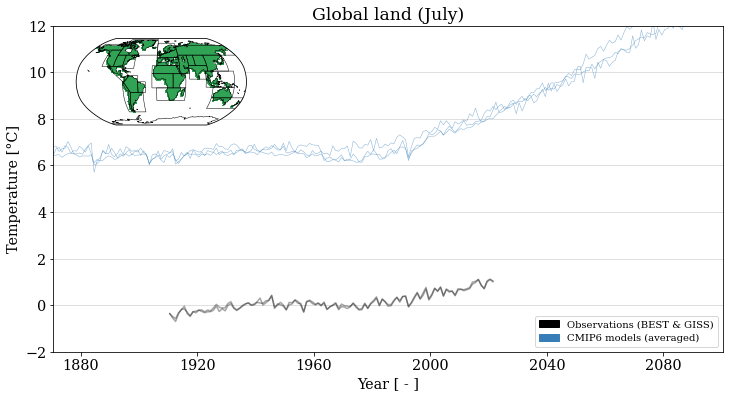

In [28]:
LST_all = {}

time_all = pd.date_range('1870-01-01', '2100-01-01', freq='YS')
time_all = time_all + pd.Timedelta(26, unit='w') - pd.Timedelta(1, unit='d')

fig=plt.figure(figsize=(12,6))

### set boundaries for y-axis
y_min = -2.0
y_max = 12.0
plt.ylim([y_min,y_max])

##create legend
obs_lg = mpatches.Patch(color="k", label="Observations (BEST & GISS)")
runs_lg = mpatches.Patch(color="#377eb8", label="CMIP6 models (averaged)")


for model in models:
        LST_all[model] = np.concatenate((LST_hist_mean[model], LST_mean[model]))
        plt.plot(time_all, LST_all[model], color='#377eb8',lw=0.5,alpha=0.6)

for dataset in datasets:
    plt.plot(time_obs[dataset][7], obs_mon[dataset][7], color="k", alpha=0.35)

plt.margins(0,0)
plt.grid(axis='y', alpha=0.5)
plt.title('Global land (July)')
plt.xlabel('Year [ - ]')
plt.ylabel('Temperature [°C]')
leg = plt.legend(handles=[obs_lg,runs_lg], loc="lower right", prop={'size': 10})

ax_sub = fig.add_axes([0.15, 0.65, 0.2, 0.2],projection=ccrs.Robinson(central_longitude=0))
mesh_srex = ax_sub.pcolormesh(lon_pc, lat_pc, idx_l_reg_gl, cmap=cmap_srex,norm=norm_srex,transform=ccrs.PlateCarree(),rasterized=True)
ax_sub.coastlines(lw=0.5)
ax_sub.add_geometries(df_srex.geometry.values, crs=ccrs.PlateCarree(), facecolor='none', edgecolor='k',lw=0.5)

plt.show()